In [4]:
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn, optim
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm


In [5]:

data_dir = "/kaggle/input/lungs-disease-dataset-4-types/Lung Disease Dataset"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")
print("Successfully excuted")


Successfully excuted


In [7]:

IMG_SIZE = 256
BATCH_SIZE = 64
EPOCHS = 20
LEARNING_RATE = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Successfully excuted")


Successfully excuted


In [8]:

transform = {
    "train": transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
    "val": transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
}

print("Successfully excuted")



Successfully excuted


Class Labels: ['Bacterial Pneumonia', 'Corona Virus Disease', 'Normal', 'Tuberculosis', 'Viral Pneumonia']
Successfully excuted


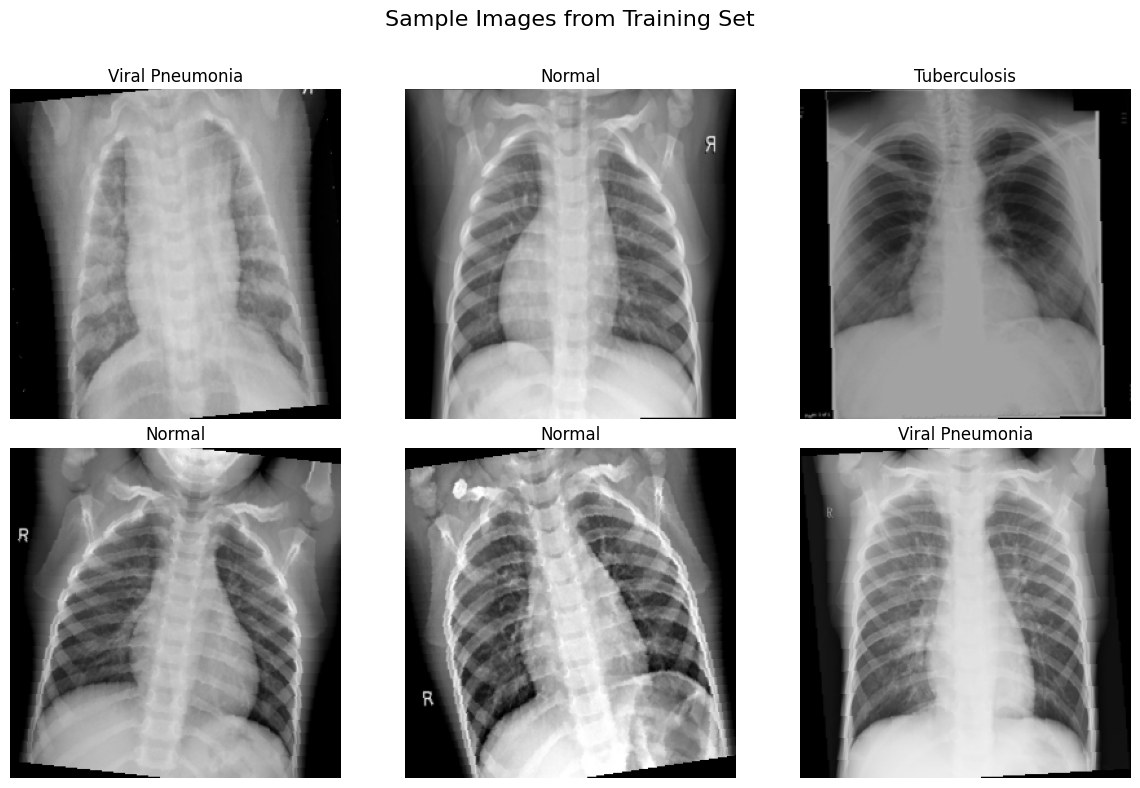

Successfully excuted


In [9]:

train_data = ImageFolder(train_dir, transform=transform["train"])
val_data = ImageFolder(val_dir, transform=transform["val"])
test_data = ImageFolder(test_dir, transform=transform["val"])

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

class_names = train_data.classes
print("Class Labels:", class_names)
print("Successfully excuted")

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip((inp * 0.5) + 0.5, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

inputs, classes_ = next(iter(train_loader))

plt.figure(figsize=(12, 8))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    imshow(inputs[i], title=class_names[classes_[i]])
plt.tight_layout()
plt.suptitle("Sample Images from Training Set", fontsize=16)
plt.subplots_adjust(top=0.88)
plt.show()

print("Successfully excuted")



In [10]:
def count_classes(dataset, name):
    print(f"\n{name} Set Distribution:")
    for cls in dataset.classes:
        count = len([x for x in dataset.imgs if cls in x[0]])
        print(f"{cls}: {count}")

count_classes(train_data, "Train")
count_classes(val_data, "Validation")
count_classes(test_data, "Test")

print("Successfully excuted")



Train Set Distribution:
Bacterial Pneumonia: 1205
Corona Virus Disease: 1218
Normal: 1207
Tuberculosis: 1220
Viral Pneumonia: 1204

Validation Set Distribution:
Bacterial Pneumonia: 401
Corona Virus Disease: 406
Normal: 402
Tuberculosis: 406
Viral Pneumonia: 401

Test Set Distribution:
Bacterial Pneumonia: 403
Corona Virus Disease: 407
Normal: 404
Tuberculosis: 408
Viral Pneumonia: 403
Successfully excuted


In [11]:

# -------------------------
# Model with Dropout
# -------------------------
model = models.densenet121(pretrained=True)
num_features = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_features, len(class_names))
)
model = model.to(device)
print("Successfully excuted")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 148MB/s] 


Successfully excuted


In [12]:

# -------------------------
# Learning Rate Scheduler
# -------------------------
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

print("Successfully excuted")

best_val_loss = float('inf')
early_stop_counter = 0
print("Successfully excuted")

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(EPOCHS):
    model.train()
    correct, total, running_loss = 0, 0, 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    val_correct, val_total, val_loss_total = 0, 0, 0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)

            _, val_preds = torch.max(val_outputs, 1)
            val_correct += (val_preds == val_labels).sum().item()
            val_total += val_labels.size(0)
            val_loss_total += val_loss.item()

    val_loss = val_loss_total / len(val_loader)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f} | Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

    # Step the learning rate scheduler
    scheduler.step()

print("Successfully excuted")


Successfully excuted
Successfully excuted


Epoch 1/20: 100%|██████████| 95/95 [03:40<00:00,  2.32s/it]


Epoch 1: Train Loss=0.5946, Train Acc=0.7679 | Val Loss=0.3343, Val Acc=0.8695


Epoch 2/20: 100%|██████████| 95/95 [02:50<00:00,  1.79s/it]


Epoch 2: Train Loss=0.3007, Train Acc=0.8817 | Val Loss=0.2634, Val Acc=0.9048


Epoch 3/20: 100%|██████████| 95/95 [02:50<00:00,  1.80s/it]


Epoch 3: Train Loss=0.2470, Train Acc=0.9050 | Val Loss=0.2639, Val Acc=0.8968


Epoch 4/20: 100%|██████████| 95/95 [02:49<00:00,  1.79s/it]


Epoch 4: Train Loss=0.2100, Train Acc=0.9169 | Val Loss=0.2381, Val Acc=0.9102


Epoch 5/20: 100%|██████████| 95/95 [02:49<00:00,  1.79s/it]


Epoch 5: Train Loss=0.1787, Train Acc=0.9319 | Val Loss=0.2762, Val Acc=0.8953


Epoch 6/20: 100%|██████████| 95/95 [02:49<00:00,  1.79s/it]


Epoch 6: Train Loss=0.1653, Train Acc=0.9399 | Val Loss=0.2804, Val Acc=0.8909


Epoch 7/20: 100%|██████████| 95/95 [02:49<00:00,  1.79s/it]


Epoch 7: Train Loss=0.1459, Train Acc=0.9455 | Val Loss=0.2851, Val Acc=0.9072


Epoch 8/20: 100%|██████████| 95/95 [02:50<00:00,  1.79s/it]


Epoch 8: Train Loss=0.0941, Train Acc=0.9686 | Val Loss=0.2319, Val Acc=0.9191


Epoch 9/20: 100%|██████████| 95/95 [02:49<00:00,  1.78s/it]


Epoch 9: Train Loss=0.0786, Train Acc=0.9752 | Val Loss=0.2354, Val Acc=0.9182


Epoch 10/20: 100%|██████████| 95/95 [02:50<00:00,  1.79s/it]


Epoch 10: Train Loss=0.0662, Train Acc=0.9813 | Val Loss=0.2342, Val Acc=0.9187


Epoch 11/20: 100%|██████████| 95/95 [02:49<00:00,  1.78s/it]


Epoch 11: Train Loss=0.0707, Train Acc=0.9800 | Val Loss=0.2349, Val Acc=0.9246


Epoch 12/20: 100%|██████████| 95/95 [02:48<00:00,  1.78s/it]


Epoch 12: Train Loss=0.0626, Train Acc=0.9803 | Val Loss=0.2336, Val Acc=0.9246


Epoch 13/20: 100%|██████████| 95/95 [02:48<00:00,  1.78s/it]


Epoch 13: Train Loss=0.0574, Train Acc=0.9828 | Val Loss=0.2367, Val Acc=0.9306


Epoch 14/20: 100%|██████████| 95/95 [02:49<00:00,  1.79s/it]


Epoch 14: Train Loss=0.0520, Train Acc=0.9843 | Val Loss=0.2427, Val Acc=0.9271


Epoch 15/20: 100%|██████████| 95/95 [02:48<00:00,  1.78s/it]


Epoch 15: Train Loss=0.0466, Train Acc=0.9861 | Val Loss=0.2403, Val Acc=0.9256


Epoch 16/20: 100%|██████████| 95/95 [02:48<00:00,  1.77s/it]


Epoch 16: Train Loss=0.0437, Train Acc=0.9884 | Val Loss=0.2401, Val Acc=0.9286


Epoch 17/20: 100%|██████████| 95/95 [02:49<00:00,  1.79s/it]


Epoch 17: Train Loss=0.0434, Train Acc=0.9896 | Val Loss=0.2414, Val Acc=0.9276


Epoch 18/20: 100%|██████████| 95/95 [02:48<00:00,  1.77s/it]


Epoch 18: Train Loss=0.0460, Train Acc=0.9883 | Val Loss=0.2423, Val Acc=0.9231


Epoch 19/20: 100%|██████████| 95/95 [02:49<00:00,  1.79s/it]


Epoch 19: Train Loss=0.0436, Train Acc=0.9888 | Val Loss=0.2401, Val Acc=0.9276


Epoch 20/20: 100%|██████████| 95/95 [02:51<00:00,  1.80s/it]


Epoch 20: Train Loss=0.0427, Train Acc=0.9886 | Val Loss=0.2429, Val Acc=0.9251
Successfully excuted


In [13]:

torch.save(model.state_dict(), "densenet121_lung_disease.pth")
print("✅ Model saved to densenet121_lung_disease.pth")



✅ Model saved to densenet121_lung_disease.pth


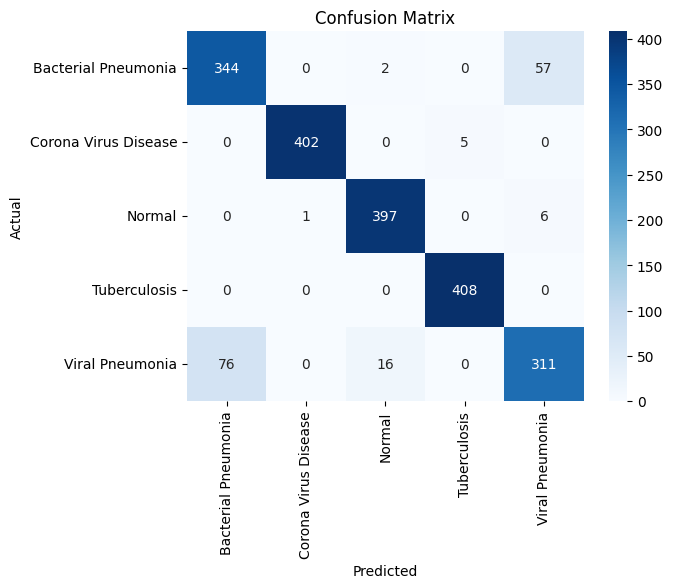


Classification Report:

                      precision    recall  f1-score   support

 Bacterial Pneumonia       0.82      0.85      0.84       403
Corona Virus Disease       1.00      0.99      0.99       407
              Normal       0.96      0.98      0.97       404
        Tuberculosis       0.99      1.00      0.99       408
     Viral Pneumonia       0.83      0.77      0.80       403

            accuracy                           0.92      2025
           macro avg       0.92      0.92      0.92      2025
        weighted avg       0.92      0.92      0.92      2025



In [14]:

def evaluate_model(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    print("\nClassification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=class_names))

evaluate_model(model, test_loader)


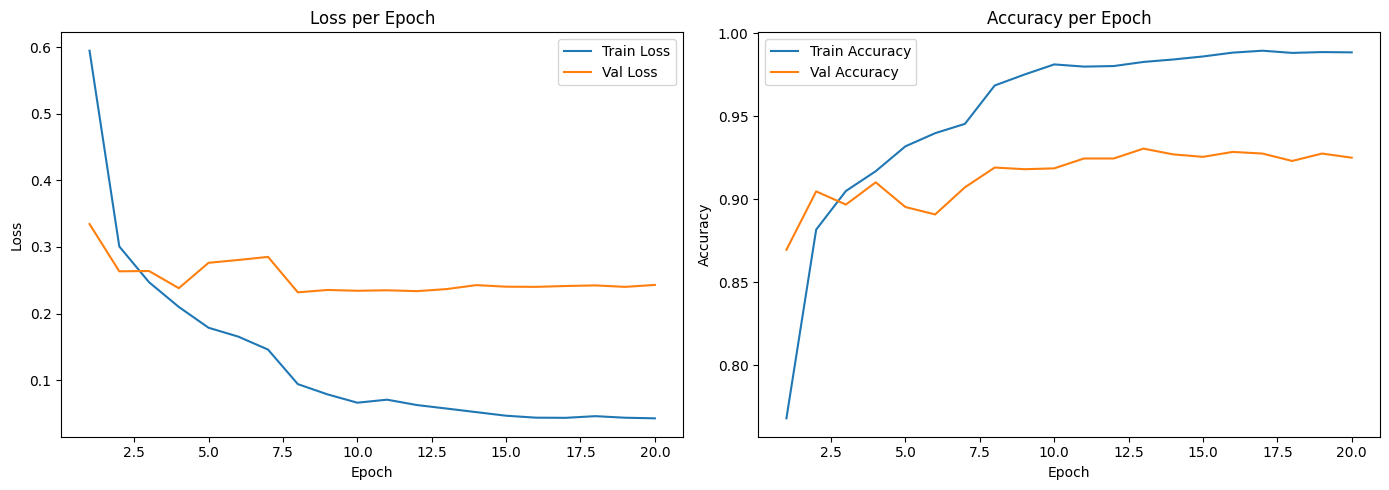

In [15]:

def plot_training_history(train_loss, val_loss, train_acc, val_acc):
    epochs_range = range(1, len(train_loss) + 1)

    plt.figure(figsize=(14, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(train_losses, val_losses, train_accs, val_accs)